# Monte Carlo Localization

引用元
* https://github.com/ryuichiueda/probrobo2017/blob/master/03.ipynb
* https://github.com/ryuichiueda/probrobo2017/blob/master/04.ipynb
* https://github.com/ryuichiueda/probrobo2017/blob/master/05.ipynb

In [1]:
%matplotlib inline
# 数値計算に必要なモジュール
import random
import math
import numpy as np
import copy
from scipy.stats import norm  # ガウス分布（正規分布）のオブジェクト

# 描画に必要なモジュール
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) #20枚以上画像を描画しても警告を出さないように設定

# ランドマークの作成・描画

ランドマーク描画用の関数を用意します。点ランドマークを3つ設置します。

In [2]:
actual_landmarks = [np.array([-0.5,0.0]),np.array([0.5,0.0]),np.array([0.0,0.5])]

def draw_landmarks(landmarks):
    xs = [ e[0] for e in landmarks]
    ys = [ e[1] for e in landmarks]
    plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")

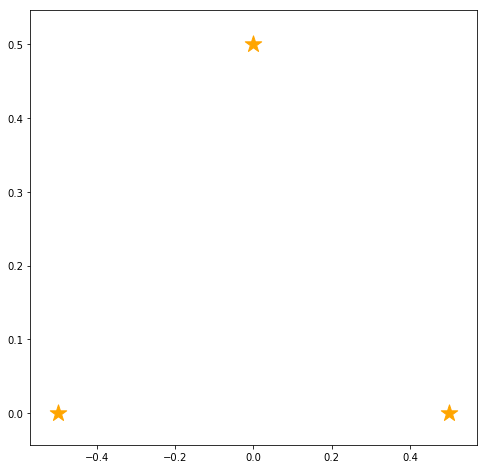

In [3]:
fig, world = plt.subplots(figsize=(8, 8))
draw_landmarks(actual_landmarks)

# ロボットの位置を計算・描画

ロボットを描画するための関数を用意します。

In [4]:
actual_x = np.array([0.3, 0.2, np.deg2rad(20)])
def draw_robot(pose):
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")

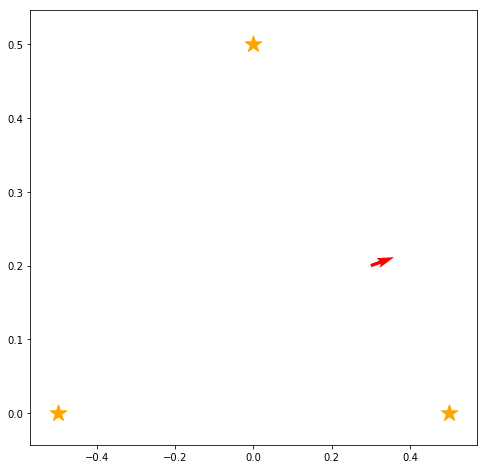

In [5]:
fig, world = plt.subplots(figsize=(8, 8))
draw_landmarks(actual_landmarks)
draw_robot(actual_x)

# ロボットからランドマークの距離・方向を描画

ロボットから見たランドマークの距離と方向を計算、描画するための関数を用意します。
ピンク色の直線で距離と方向を計算し、描画します。

In [6]:
def relative_landmark_pos(pose,landmark):
    x, y, theta = pose
    lx, ly = landmark
    distance = math.sqrt((x - lx)**2 + (y - ly)**2)
    direction = math.atan2(ly - y, lx - x) - theta
    return (distance, direction, lx, ly)

def draw_observation(pose, measurement):
    x, y, theta = pose
    distance, direction, lx, ly = measurement
    lx = distance * math.cos(theta + direction) + x
    ly = distance * math.sin(theta + direction) + y
    plt.plot([pose[0], lx], [pose[1], ly], color="pink")
    
def draw_observations(pose, measurements):
    for m in measurements:
        draw_observation(pose, m)

[(0.8246211251235323, -3.2456798408617948, -0.5, 0.0), (0.28284271247461906, -1.1344640137963142, 0.5, 0.0), (0.4242640687119285, 2.0071286397934789, 0.0, 0.5)]


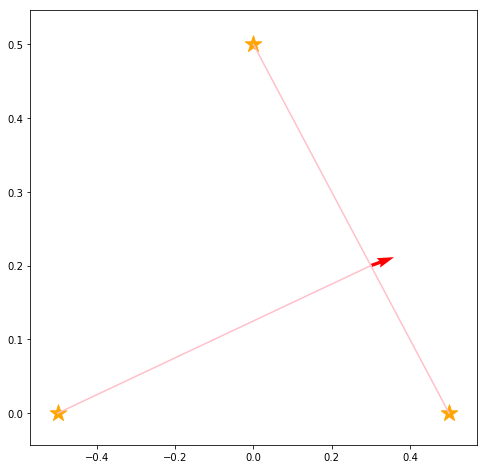

In [7]:
measurements = [ relative_landmark_pos(actual_x,e) for e in actual_landmarks]
print(measurements)

fig, world = plt.subplots(figsize=(8, 8))
draw_landmarks(actual_landmarks)
draw_robot(actual_x)
draw_observations(actual_x, measurements)

# ロボットからランドマークを観測、観測した距離・方向を描画

ロボットの観測値（センサ値）にはノイズをのせます。また、観測範囲を限定します。
ロボットのセンサを使ってランドマークを「観測」するための関数を作成します。

先ほどまではロボットからランドマークの中心へまっすぐな（方向・距離がどちらも正しい）直線が引かれていました。
今回は観測結果にノイズがランダムに乗るため、実際のランドマークまでの方向と距離と観測結果が一致しない場合があります（ほとんど一致しない）。
描画には先ほどの関数をそのまま使用します。

* 観測範囲
  * 観測範囲はロボットの左右90[deg]
* 雑音
  * 距離計測に真値の10%の標準偏差の雑音
  * 方向計測に標準偏差5degの雑音

In [8]:
def observation(pose, landmark):
    actual_distance,actual_direction,lx,ly = relative_landmark_pos(pose,landmark)
    if (math.cos(actual_direction) < 0.0):
        return None # 観測範囲外なら無視
    measured_distance = random.gauss(actual_distance, actual_distance * 0.1)
    measured_direction = random.gauss(actual_direction, np.deg2rad(5))
    return (measured_distance, measured_direction, lx, ly)

def observations(pose, landmarks):
    measurements = []
    for landmark in landmarks:
        measurement = observation(pose, landmark)
        if measurement == None:
            pass
        else:
            measurements.append(measurement)
    return measurements

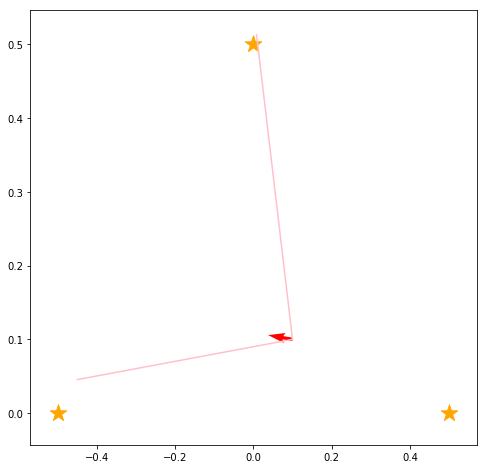

In [9]:
fig, world = plt.subplots(figsize=(8, 8))
actual_x = np.array([0.1,0.1,np.deg2rad(170)])
measurements = observations(actual_x, actual_landmarks)

draw_landmarks(actual_landmarks)
draw_robot(actual_x)
draw_observations(actual_x, measurements)

# motion updateの実装

ロボットを描画できるようになったのでmotion updateを実装します。
移動ロボットの状態遷移をシミュレーションします。

In [10]:
class Particle:
    """
    パーティクルフィルタのためのクラスで、構造体として利用します。
    """
    def __init__(self,w,p=[0.0,0.0,0.0]):
        self.pose = np.array(p)
        self.weight = w
    
    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)
        

def f(x_old,u):
    """
    ロボットとパーティクルを動かすための関数
    移動の際に移動方向に3[deg]、移動量に10%、
    回転の際に回転角度に10%の雑音をのせます。
    """
    pos_x, pos_y, pos_theta = x_old
    act_fw, act_rot = u
    
    act_fw = random.gauss(act_fw,act_fw/10)
    dir_error = random.gauss(0.0, np.deg2rad(3.0))
    act_rot = random.gauss(act_rot,act_rot/10)
    
    pos_x += act_fw * math.cos(pos_theta + dir_error)
    pos_y += act_fw * math.sin(pos_theta + dir_error)
    pos_theta += act_rot
    
    return np.array([pos_x, pos_y, pos_theta])


def draw(pose,particles):
    """
    パーティクルを描画するための関数
    """
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2])*e.weight for e in particles]  #パーティクルの重みによって矢印（ロボット）の長さを変更
    vys = [math.sin(e.pose[2])*e.weight for e in particles]  #パーティクルの重みによって矢印（ロボット）の長さを変更
    plt.quiver(xs,ys,vxs,vys,color="blue",label="particles")
    
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")

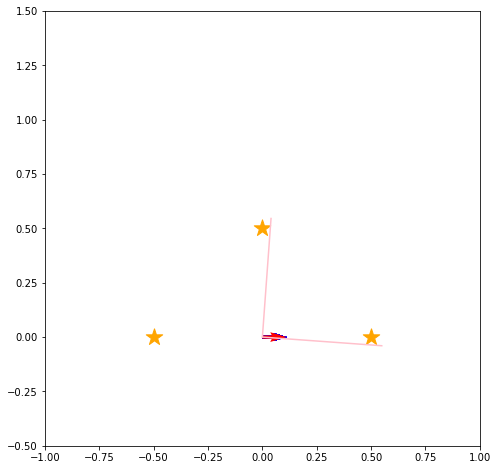

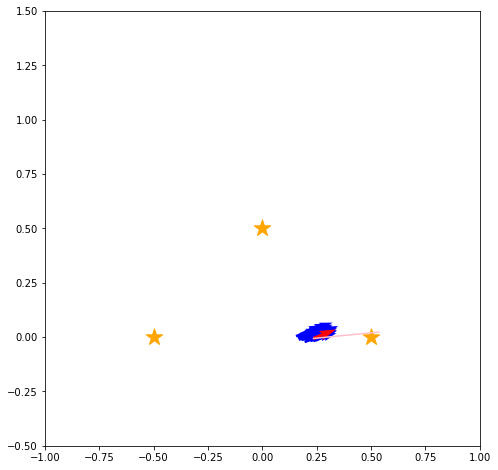

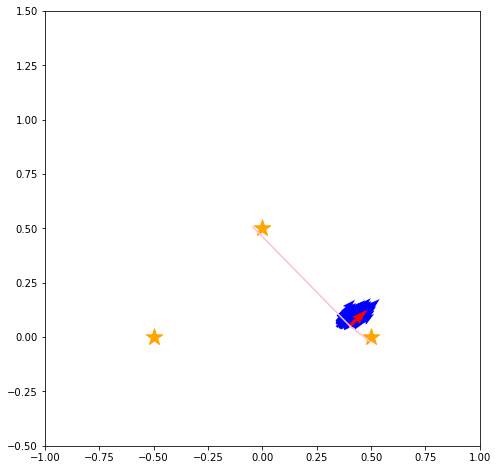

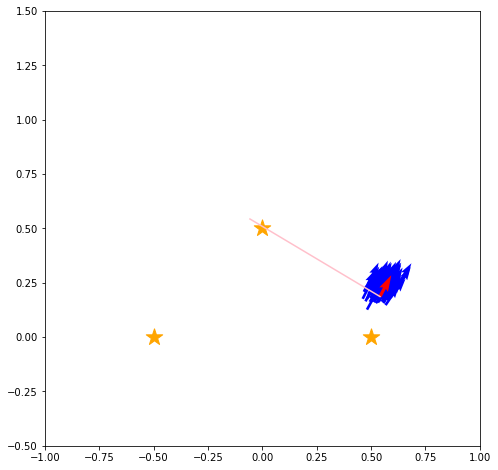

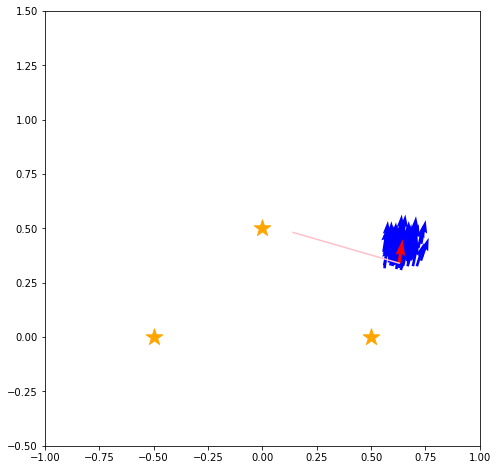

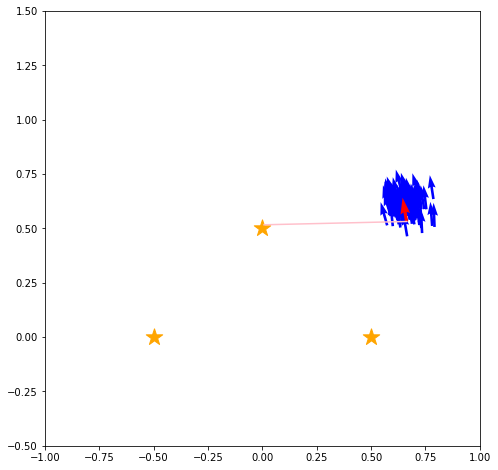

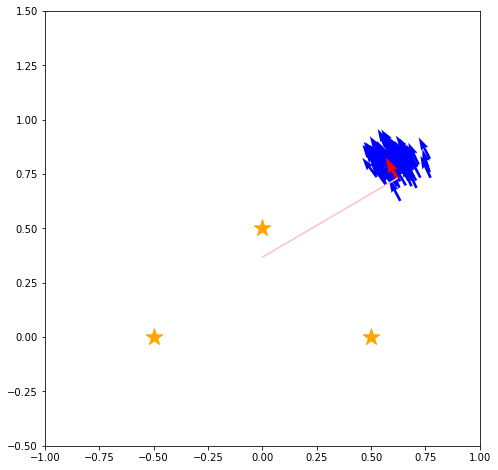

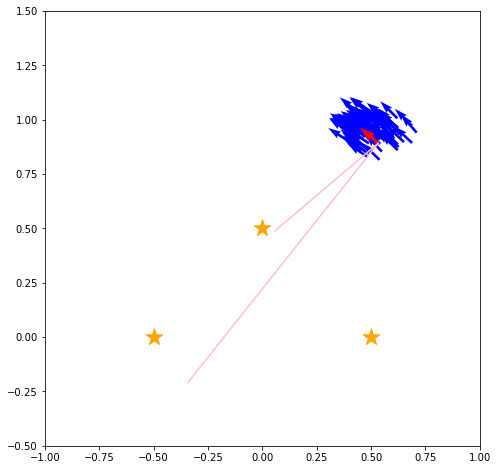

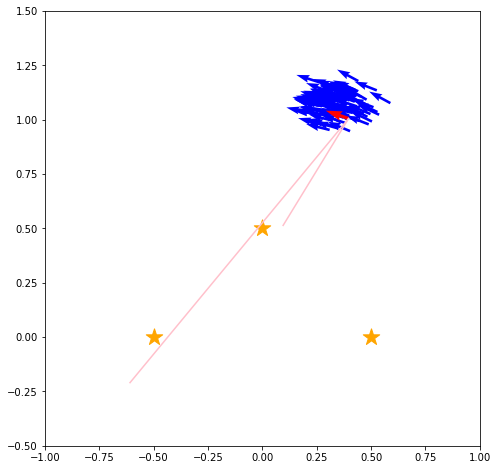

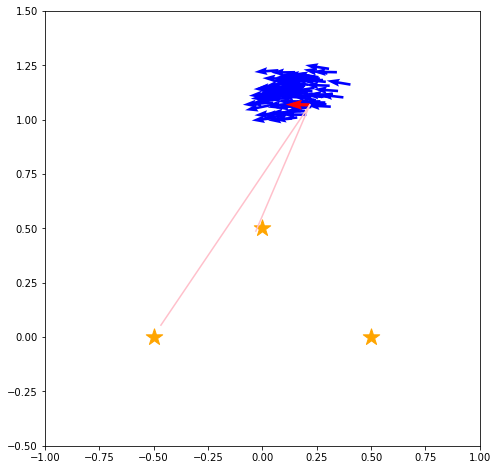

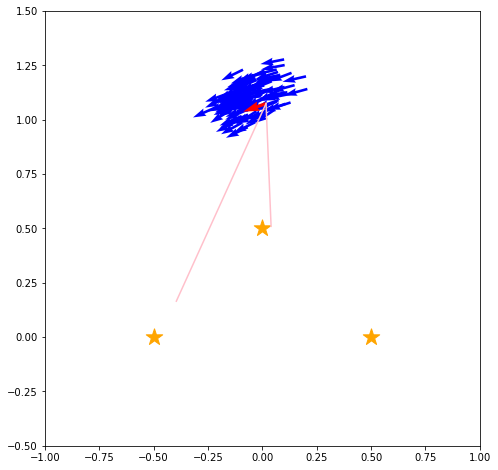

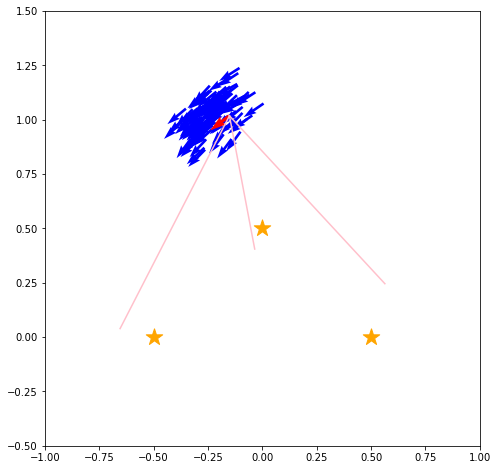

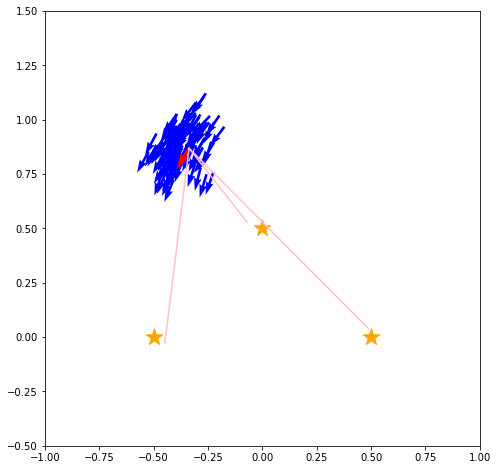

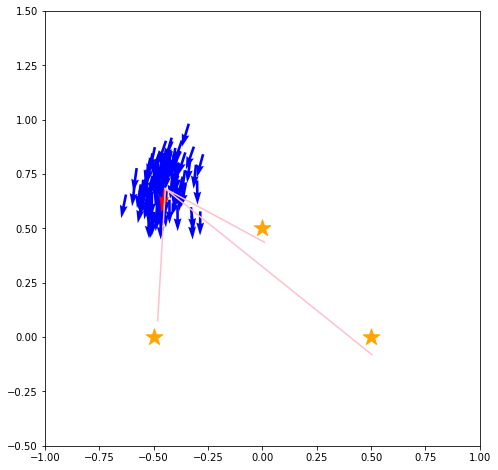

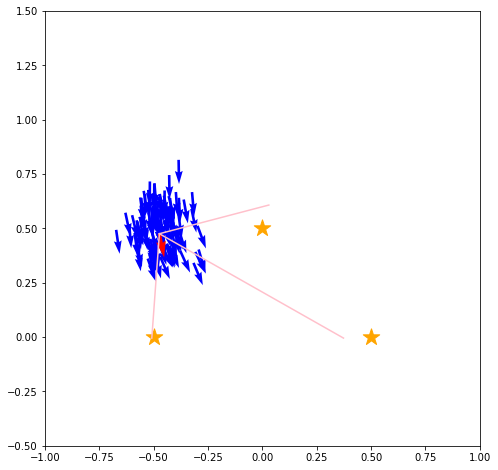

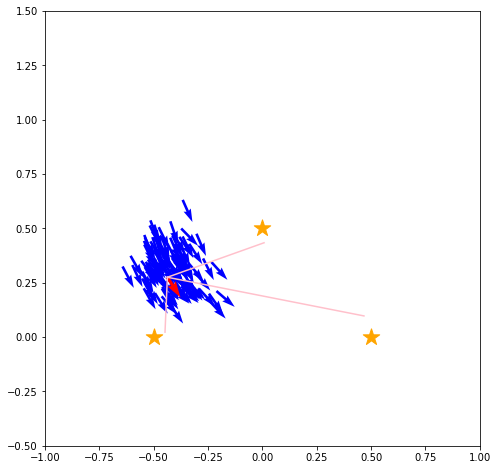

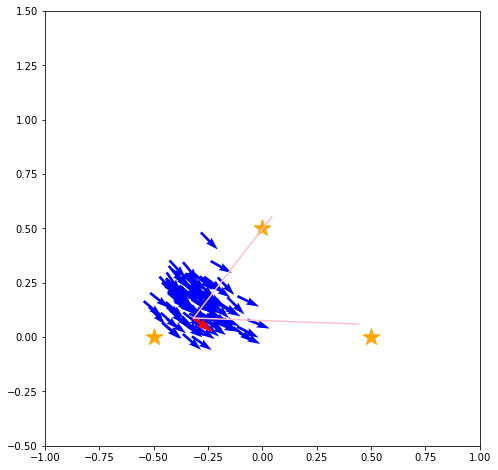

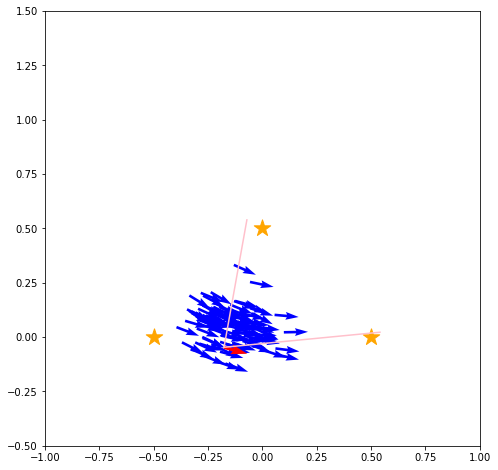

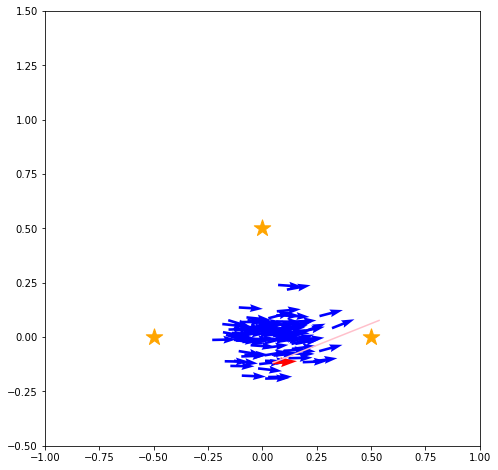

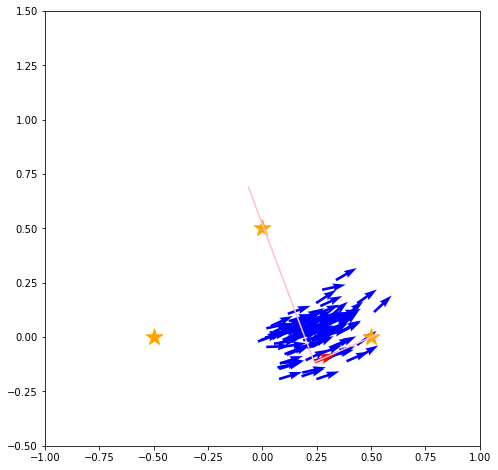

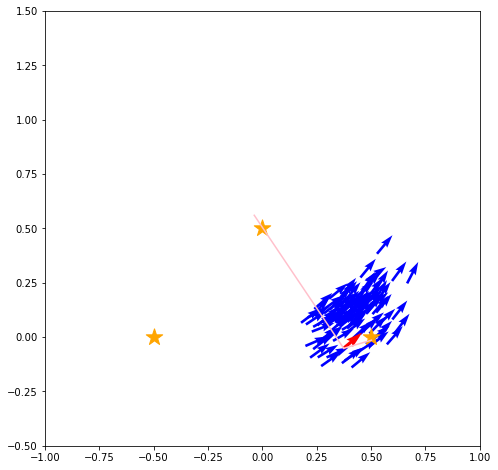

In [11]:
actual_x = np.array([0.0,0.0,0.0])   #ロボットの最初の姿勢を定義
particles = [Particle(w=1.0/100,p=[0.0,0.0,0.0]) for i in range(100)]  #パーティクルを100個用意
u = np.array([0.2, np.deg2rad(20)]) #ロボットの移動距離・方向を定義

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]
for i in range(20):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    measurementss.append(observations(actual_x,actual_landmarks))

    for p in particles:
        p.pose = f(p.pose,u)
    particle_path.append(copy.deepcopy(particles))

for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])

# sensor updateの実装

ベイズの定理を使い、自己位置推定を行います。
観測をパーティクルの分布に反映させます。具体的には、パーティクルの姿勢と観測されたランドマークの位置の矛盾の度合いでパーティクルの重みを変化させます。

In [12]:
def likelihood(pose, measurement):
    """
    パーティクルの姿勢と観測結果を比較する関数
    """
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    
    # パーティクルの姿勢から観測されるはずのランドマークの距離と向き
    rel_distance, rel_direction, tmp_x, tmp_y = relative_landmark_pos(pose,(lx,ly))

    # 誤差をガウスで評価
    return norm.pdf(x = (distance - rel_distance), loc = 0.0, scale = rel_distance / 10.0)  \
             * norm.pdf(x = (direction - rel_direction), loc = 0.0, scale = np.deg2rad(5.0))

def change_weights(particles, measurement):
    """
    パーティクル群の重みを変更する関数
    """
    for p in particles:
        p.weight *= likelihood(p.pose, measurement)
        
    # 重みの合計を1に保つ
    ws = [ p.weight for p in particles ]
    s = sum(ws)
    if s <= 0:
        print("weights <= 0")
    else:
        for p in particles: p.weight = p.weight / s

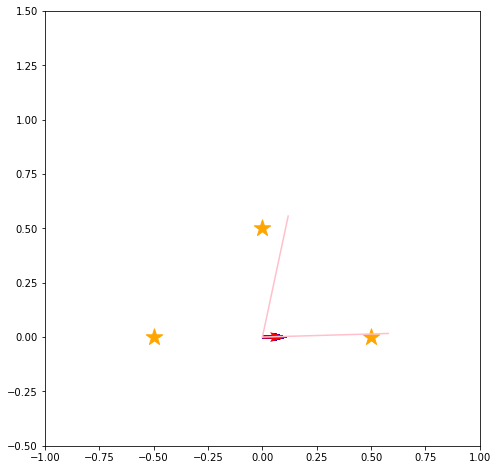

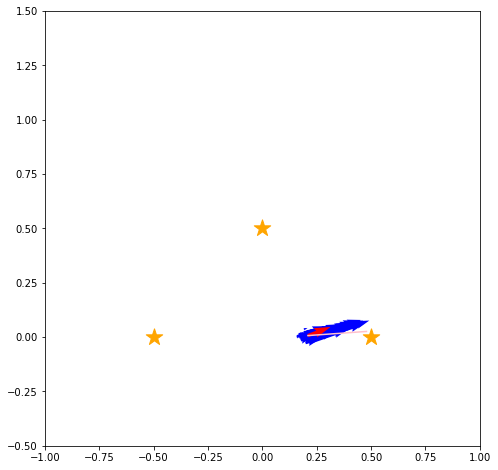

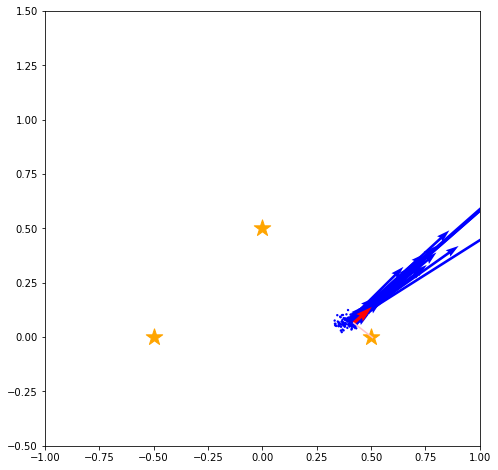

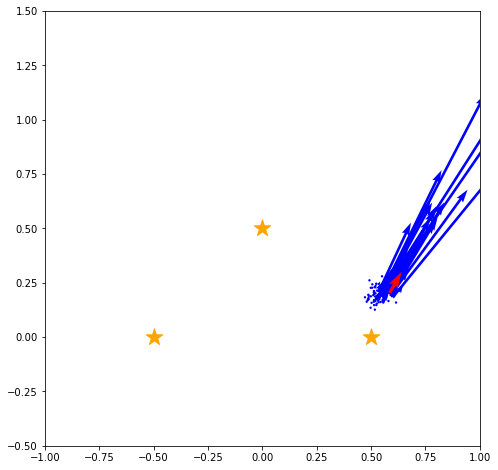

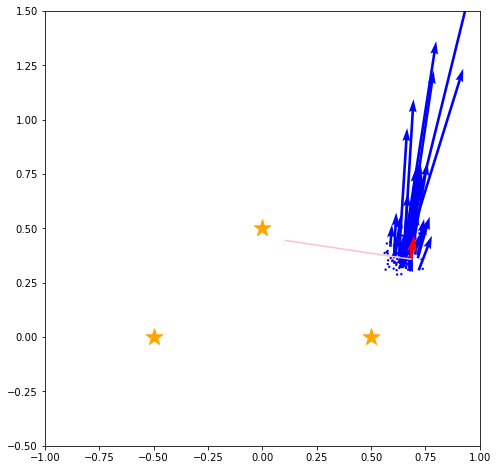

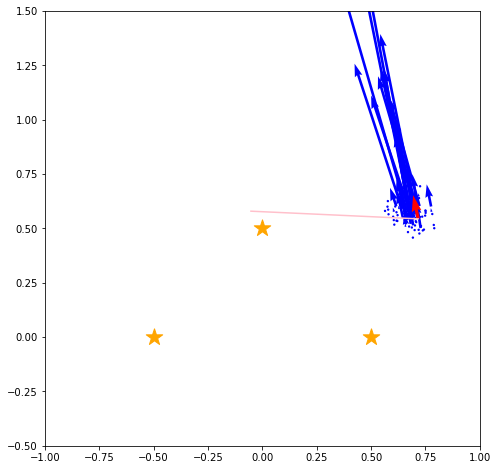

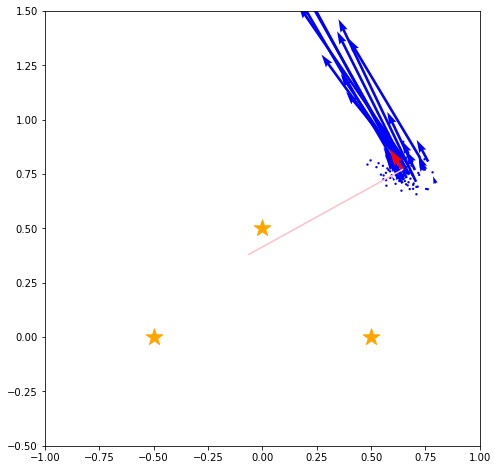

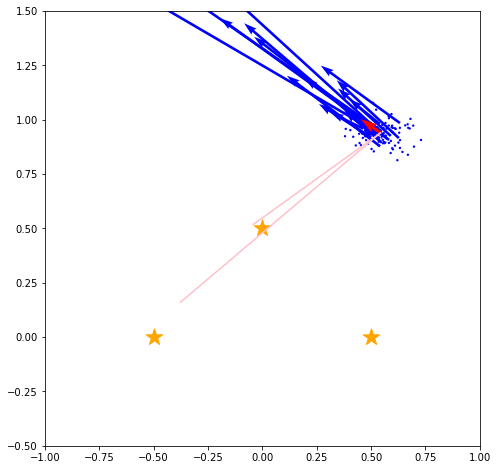

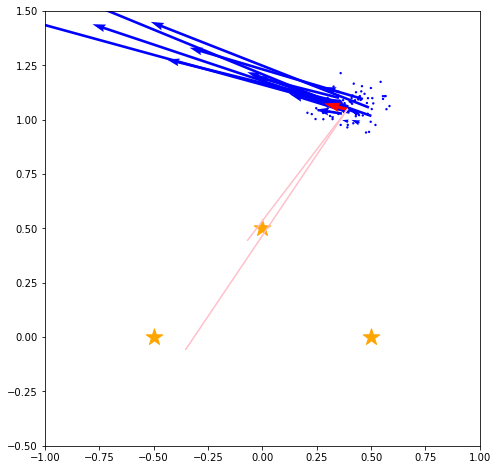

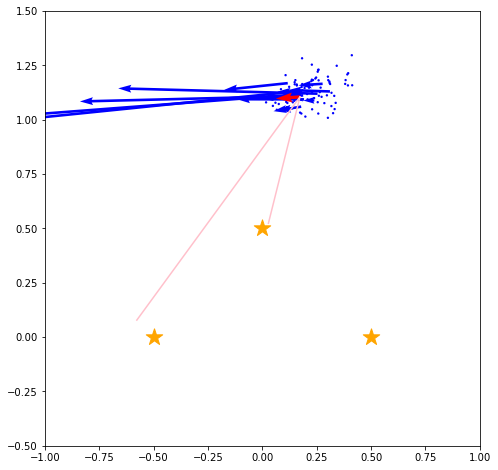

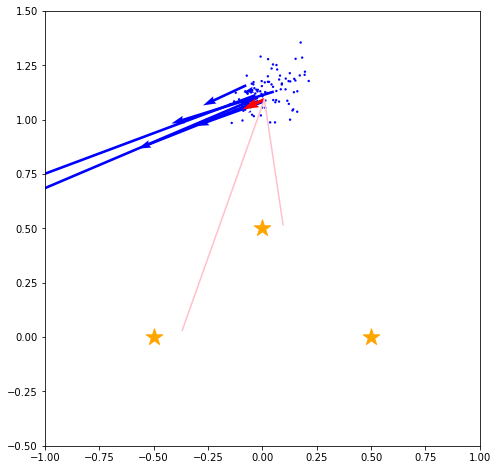

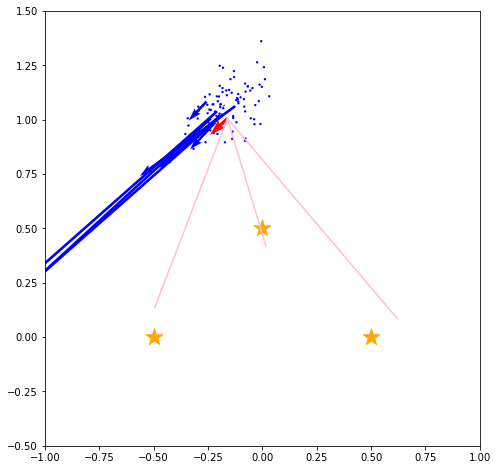

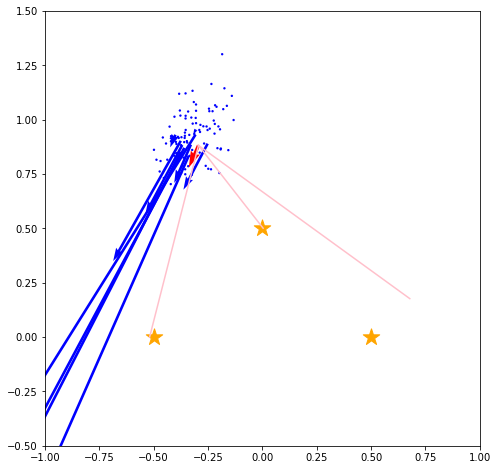

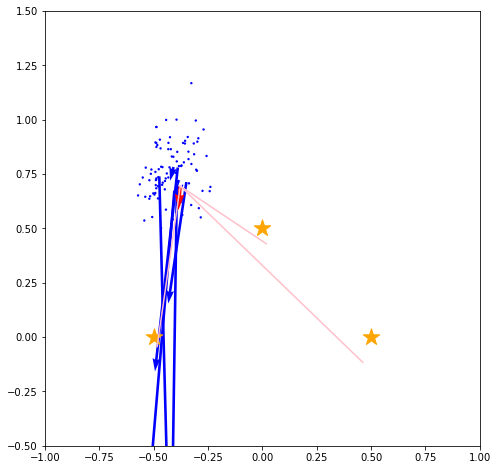

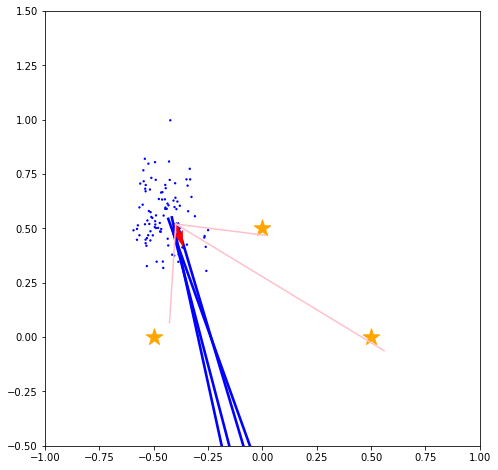

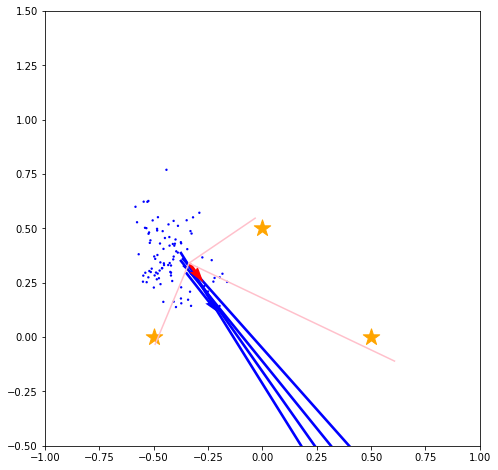

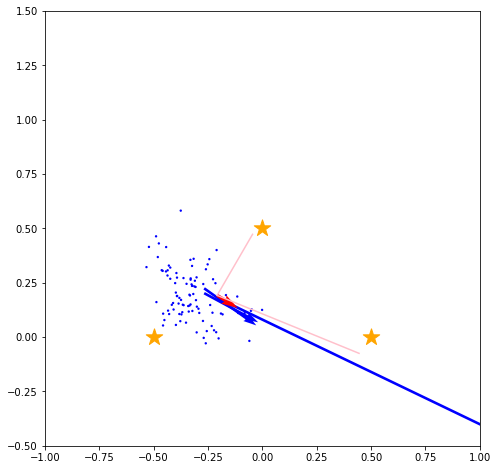

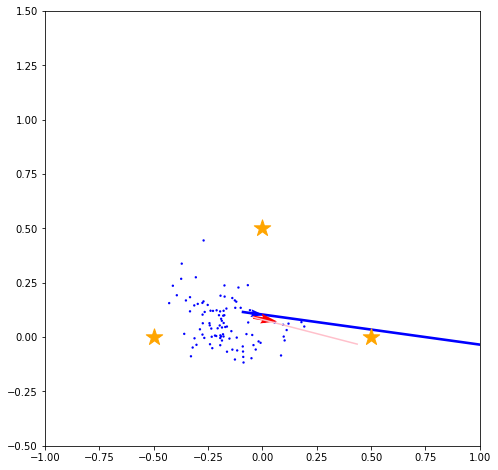

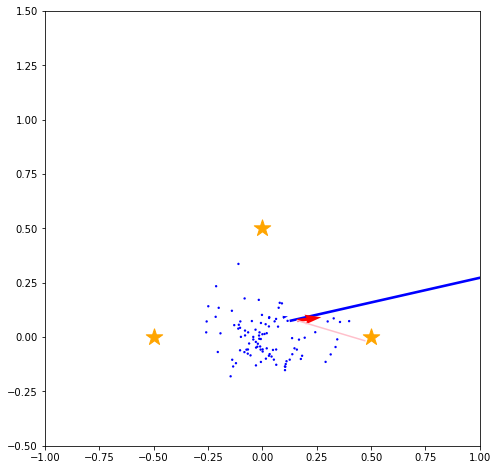

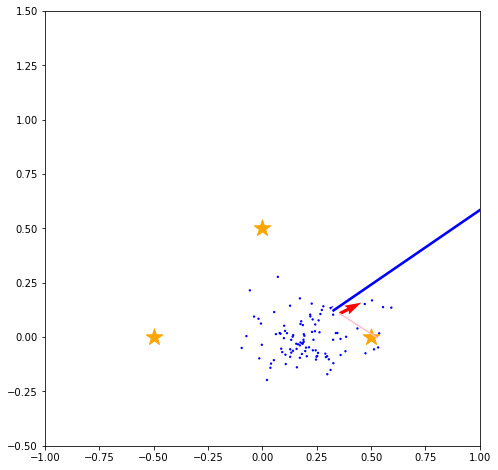

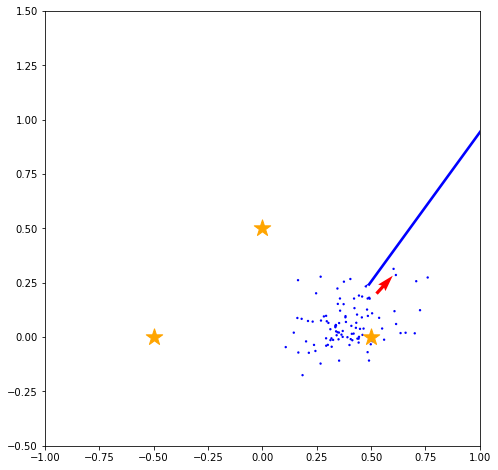

In [13]:
actual_x = np.array([0.0,0.0,0.0])   #ロボットの最初の姿勢を定義
particles = [Particle(w=1.0/100,p=[0.0,0.0,0.0]) for i in range(100)]  #パーティクルを100個用意
u = np.array([0.2, np.deg2rad(20)]) #ロボットの移動距離・方向を定義

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]

for i in range(20):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    ms = observations(actual_x,actual_landmarks)
    measurementss.append(ms)

    for p in particles:
        p.pose = f(p.pose,u)
    
    for m in ms:
        change_weights(particles, m)
    particle_path.append(copy.deepcopy(particles))


# 計算結果を描画
for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])

# resamplingの実装

ここまでのやり方では観測をパーティクルの分布に反映させました。
しかし、重みが特定のパーティクルに偏るという問題があります。
そこで系統抽出法を用いてパーティクルをリサンプリングしながら自己位置の推定を行います。

In [14]:
def resample(particles):
    #確率分布のリストを作成
    accum = []
    sm = 0.0
    for p in particles:
        accum.append(p.weight + sm)
        sm += p.weight
    #print(accum, sm)
    #サンプリングのためのポインタを生成
    pointer = random.uniform(0.0,1.0/len(particles))
    #print(pointer)
    
    #生成したポインタを元に確率分布のリストからリサンプリング
    new_particles = []
    particles_num = len(particles)

    while pointer < 1.0:
        if accum[0] >= pointer:
            new_particles.append(Particle(w=1.0/particles_num, p=copy.deepcopy(particles[0].pose)))
            pointer += 1.0/particles_num
        else:
            accum.pop(0)
            particles.pop(0)

    return new_particles

In [15]:
# リサンプリングの処理前と処理後を確認

print("before")
for p in particles:
    print(p)

particles = resample(particles)

print("after")
for p in particles:
    print(p)

before
pose: [ 0.61392167  0.2854426   7.45470471] weight: 6.54472729594e-106
pose: [ 0.2136746  -0.07226265  6.90068134] weight: 3.96554330374e-131
pose: [ 0.48411792  0.17755826  6.83535406] weight: 3.38332210054e-44
pose: [ 0.30098102 -0.03578903  6.92533871] weight: 1.32781719316e-89
pose: [ 0.48705813  0.23737748  7.22463179] weight: 0.998042204103
pose: [ 0.33774075  0.0558882   6.88072117] weight: 7.29437294912e-66
pose: [ 0.32513424 -0.01285996  6.99270465] weight: 1.04827411033e-95
pose: [ 0.2679817   0.27773455  6.75348657] weight: 6.71145946148e-167
pose: [ 0.18050405  0.08396735  6.60995146] weight: 1.16567042739e-139
pose: [  3.17603251e-01  -5.82982506e-03   6.68060627e+00] weight: 5.55516353507e-116
pose: [ 0.50617768 -0.01908238  6.97404529] weight: 1.09033843135e-63
pose: [ 0.34692057  0.15251356  7.19977951] weight: 3.84183842906e-39
pose: [ 0.45874831  0.18646464  6.93827014] weight: 0.0
pose: [ 0.34147554  0.00840944  6.75985404] weight: 1.43179379564e-63
pose: [ 0.

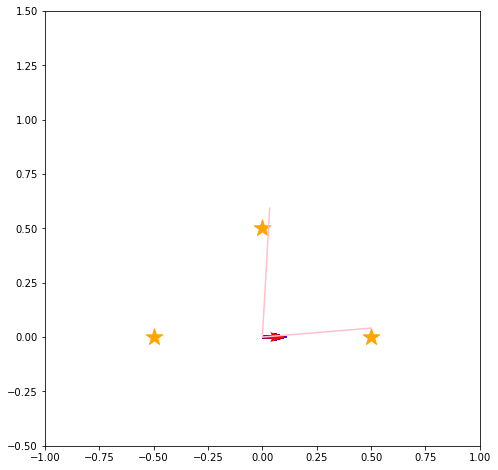

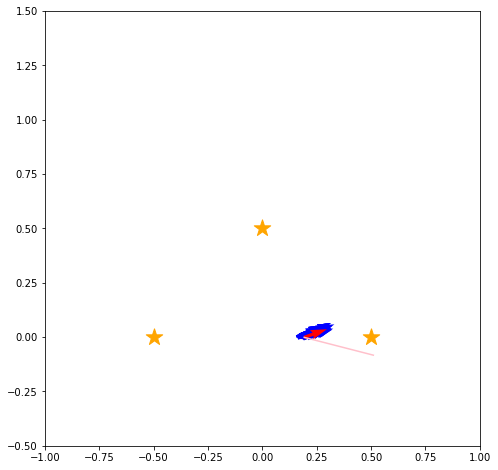

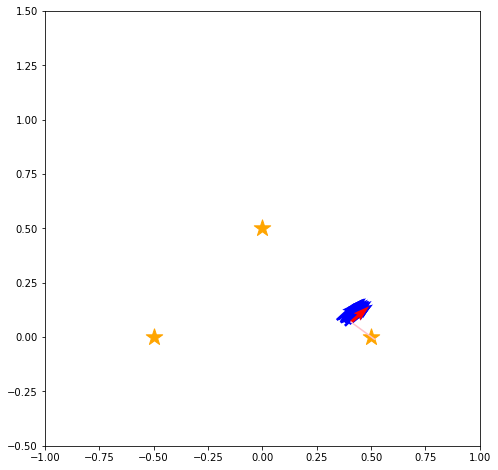

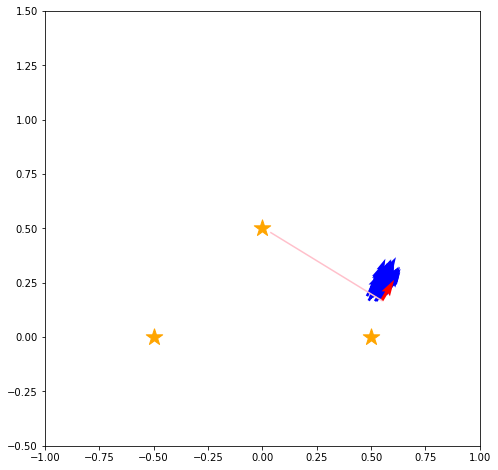

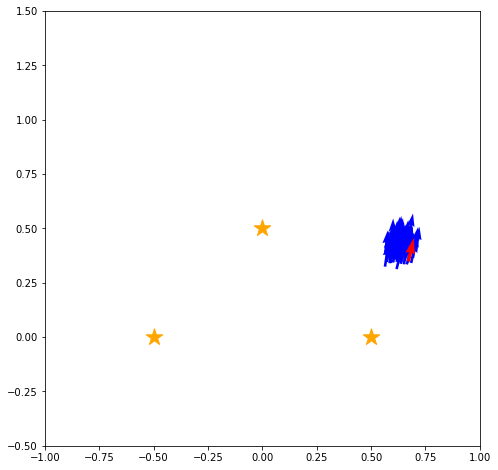

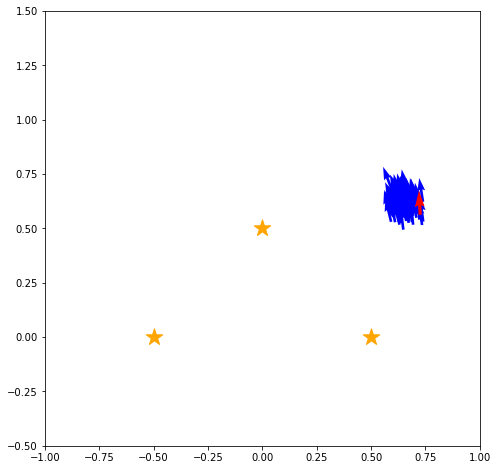

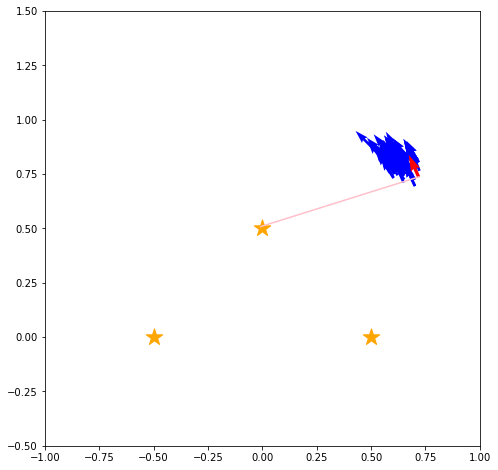

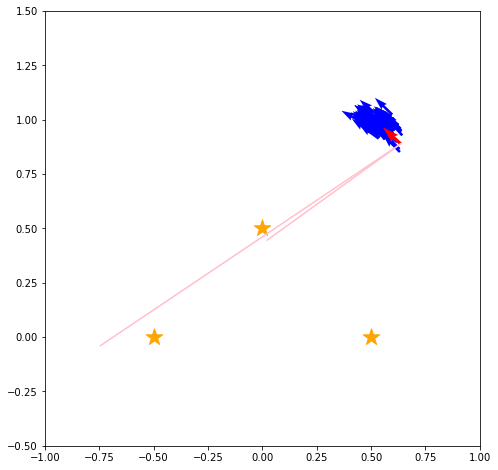

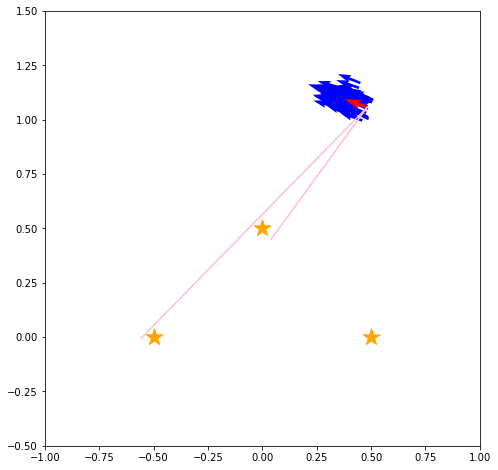

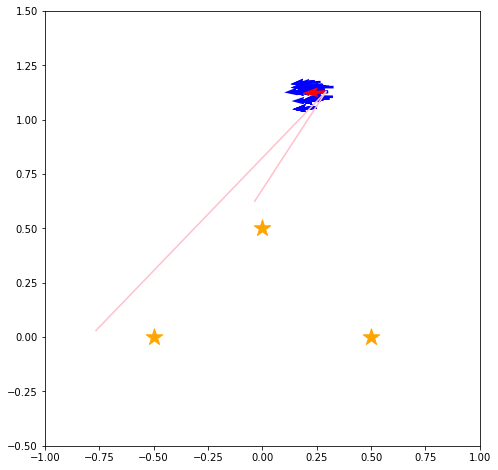

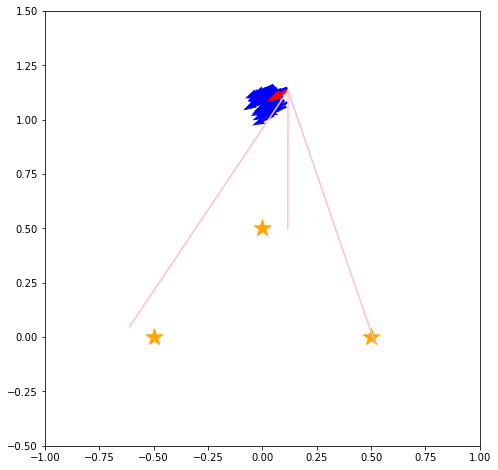

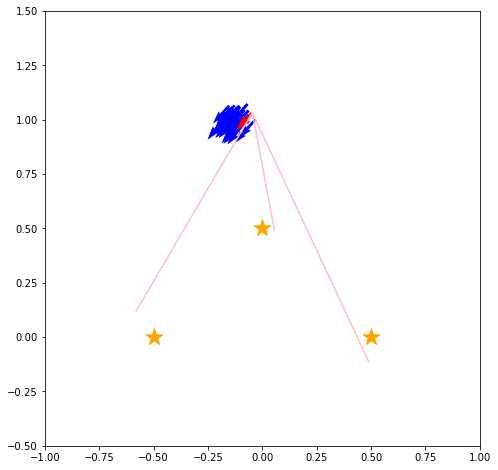

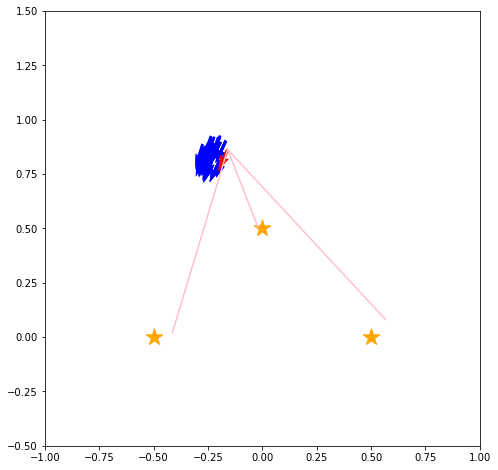

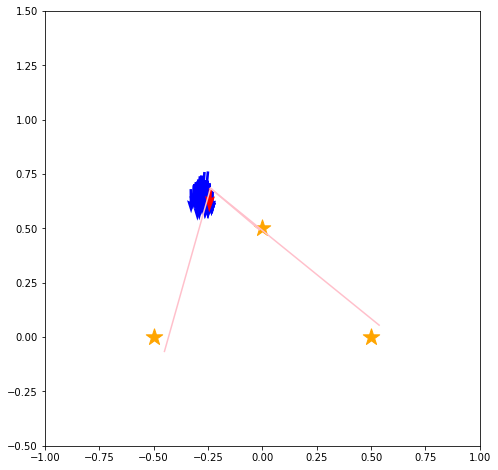

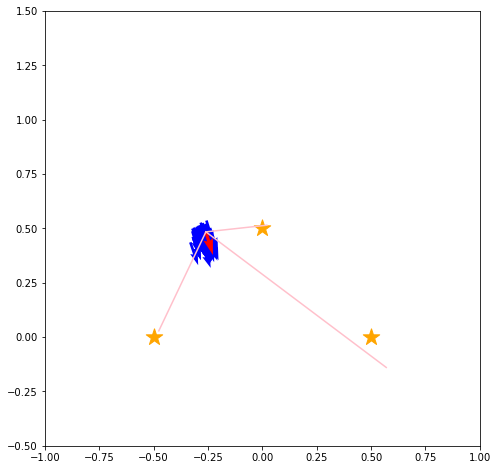

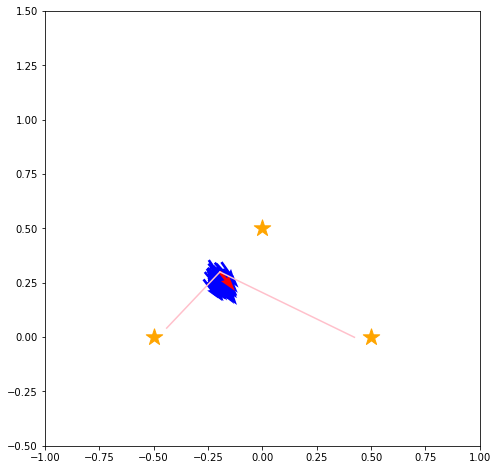

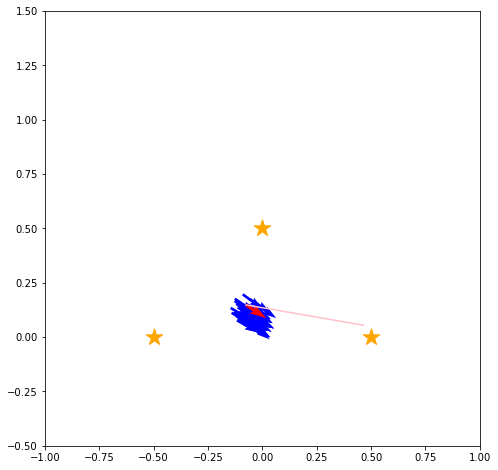

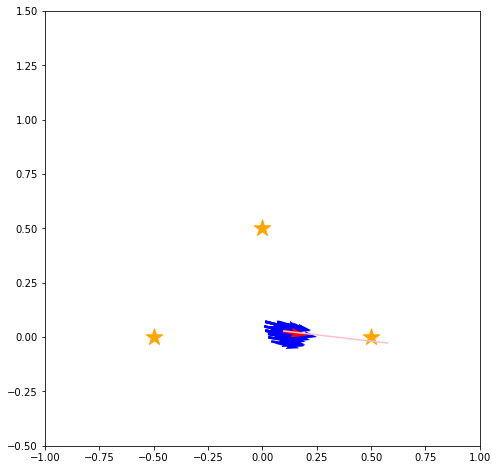

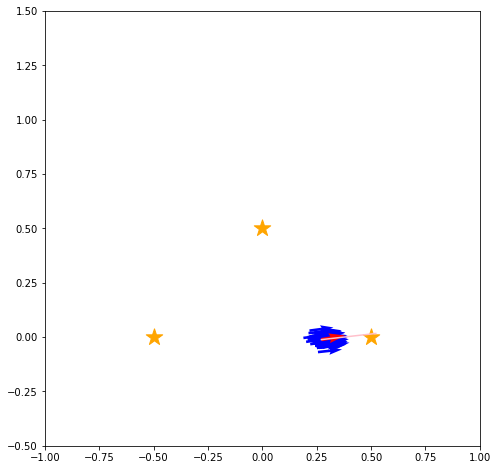

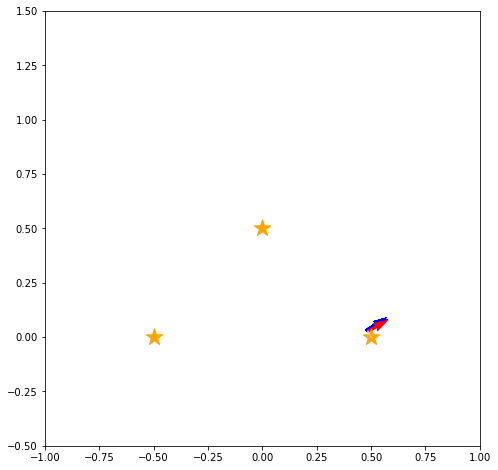

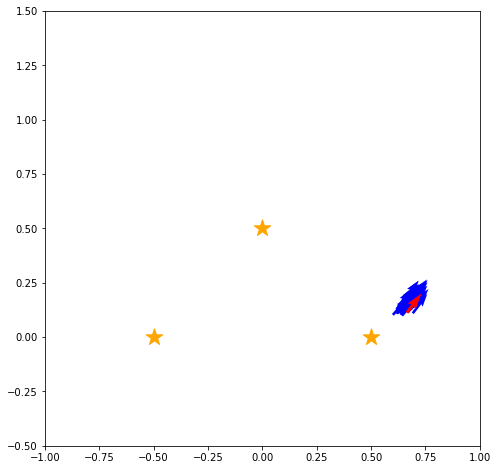

In [16]:
actual_x = np.array([0.0,0.0,0.0])   #ロボットの最初の姿勢を定義
particles = [Particle(w=1.0/100,p=[0.0,0.0,0.0]) for i in range(100)]  #パーティクルを100個用意
u = np.array([0.2, np.deg2rad(20)]) #ロボットの移動距離・方向を定義

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]

for i in range(20):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    ms = observations(actual_x,actual_landmarks)
    measurementss.append(ms)
    
    for p in particles:
        p.pose = f(p.pose,u)
    
    for m in ms:
        change_weights(particles, m)
    
    particles = resample(particles)
    particle_path.append(copy.deepcopy(particles))

# 計算結果を描画
for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])